# Libs and raw DataFrame

In [245]:
import pandas as pd
import math as mt
from math import radians, cos, sin, asin, sqrt
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from time import perf_counter
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
import pickle

We already created and treated our base df. We chose to separate the creation of the df and the rest of the project to make things easier to understand. But all the steps to do so can be found in the notebook 'creating_and_treating_df' 

Here, we will just load the file 

In [23]:
#loading our df

freight_df = pd.read_csv('freight_df\olist_freight_base_df.csv')

freight_df.head(3)

,freight_value,price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,customer_lat,customer_lng,seller_lat,seller_lng
0,13.29,58.9,650.0,28.0,9.0,14.0,RJ,SP,-21.762775,-41.309633,-22.496953,-44.127492
1,17.96,55.9,650.0,28.0,9.0,14.0,GO,SP,-17.884337,-51.716990,-22.496953,-44.127492
2,18.33,64.9,650.0,28.0,9.0,14.0,MG,SP,-19.914323,-43.975703,-22.496953,-44.127492


# Initial Feature Engineering

We could start this project investigating the data, correlation between variables, how good our features are, etc. But considering our DataFrame and goal, it is very clear that we need to create at least two new features: 

+ The delivery distance based on the coordinates of customers and sellers
+ The volume of the package based on the measurements 

So we chose to first create the obvious features, and later check the rest of the data.

Please note that we intend to use an Tree-based model, so we wont need to apply any normalization 

In [24]:
#Lets start with the delivery distance
#We can find it using Haversine formula

def coordinates_distance(df):
    #coordinates in radians 
    lng_seller = radians(df.seller_lng)
    lat_seller = radians(df.seller_lat)
    lng_customer = radians(df.customer_lng)
    lat_customer = radians(df.customer_lat)
    #variables for use in formula 
    dist_lat = lat_customer - lat_seller
    dist_lng = lng_customer - lng_seller
    
    # Radius of earth in kilometers.
    r = 6371
    # Haversine formula
    h = sin(dist_lat/2)**2 + cos(lat_seller)*cos(lat_customer)*sin(dist_lng / 2)**2
    d = 2*r*asin(sqrt(h))
    
    df['delivery_distance'] = d
    return df

In [25]:
freight_df2 = freight_df.apply(coordinates_distance,axis =1)

freight_df2.sample(3)

,freight_value,price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,customer_lat,customer_lng,seller_lat,seller_lng,delivery_distance
13028,21.40,139.9,4550.0,20.0,20.0,20.0,SP,SP,-23.955283,-46.273865,-22.275249,-48.543584,297.944259
97084,9.03,59.9,750.0,38.0,15.0,33.0,SP,SP,-23.561190,-46.474486,-23.568755,-46.653409,18.255657
36638,25.31,119.0,6550.0,20.0,20.0,20.0,RS,MG,-29.663777,-50.776393,-20.940578,-45.827237,1089.751104


In [26]:
#the volume will be esier 

freight_df2['product_volume'] = (freight_df2['product_length_cm']*
                                 freight_df2['product_height_cm']*
                                 freight_df2['product_width_cm'])

freight_df2.sample(1)

,freight_value,price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,customer_lat,customer_lng,seller_lat,seller_lng,delivery_distance,product_volume
49796,32.98,99.5,9100.0,42.0,13.0,39.0,MG,ES,-21.550148,-45.735009,-20.278513,-40.411675,570.681841,21294.0


# Dealing with outliers

For the next steps we will need to start checking correlations and understand which features we should keep, which we should transform and which we should drop. 

So now it seems like a good idea to investigate possible outliers, so we can work with a cleaner DataFrame.

count    110179.000000
mean         19.949359
std          15.699213
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64

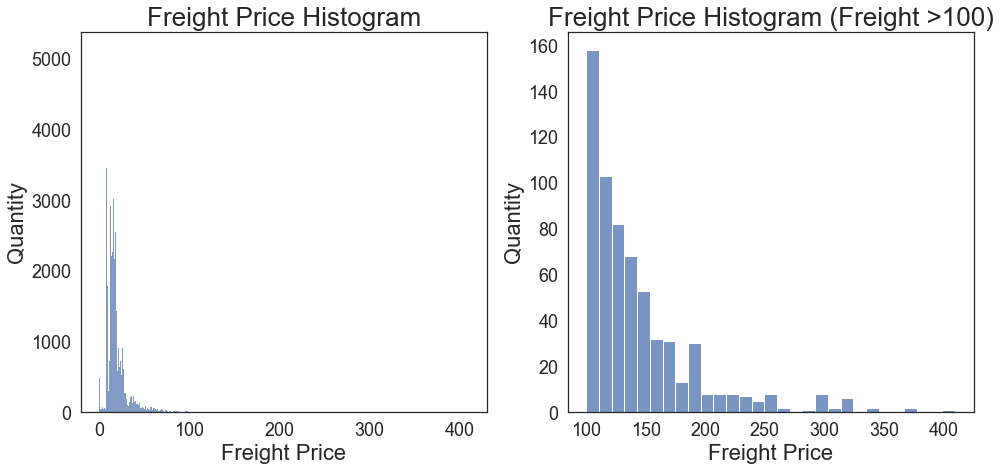

There is :
638 freight prices higher then 100$
66 freight prices higher then 200$


In [47]:
#lets start looking at freight values

display(freight_df2.freight_value.describe())

sns.set_style('white')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,7))

sns.histplot(data =freight_df2.freight_value,ax = ax1)
ax1.set_title("Freight Price Histogram",fontsize = 26)
ax1.set_xlabel("Freight Price",fontsize=22)
ax1.set_ylabel("Quantity",fontsize=22)
ax1.tick_params(labelsize=18)

high_freight = freight_df2[freight_df2.freight_value>100]
sns.histplot(data =high_freight.freight_value,ax = ax2)
ax2.set_title("Freight Price Histogram (Freight >100)",fontsize = 26)
ax2.set_xlabel("Freight Price",fontsize=22)
ax2.set_ylabel("Quantity",fontsize=22)
ax2.tick_params(labelsize=18)

plt.show()
print(f'There is :\n{len(high_freight)} freight prices higher then 100$'
      f'\n{len(high_freight[high_freight.freight_value>200])} freight prices higher then 200$')

We have some very high freight prices. 

If those values are associated with big weights and\or long delivery distances, it may not be an issue. Otherwise, we are dealing with outliers and we should drop those values before training our model.


In [55]:
high_freight.head(1)

,freight_value,price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,customer_lat,customer_lng,seller_lat,seller_lng,delivery_distance,product_volume
1160,185.73,79.99,250.0,22.0,10.0,18.0,BA,SP,-10.504092,-40.326104,-23.659364,-46.523183,1603.484491,3960.0


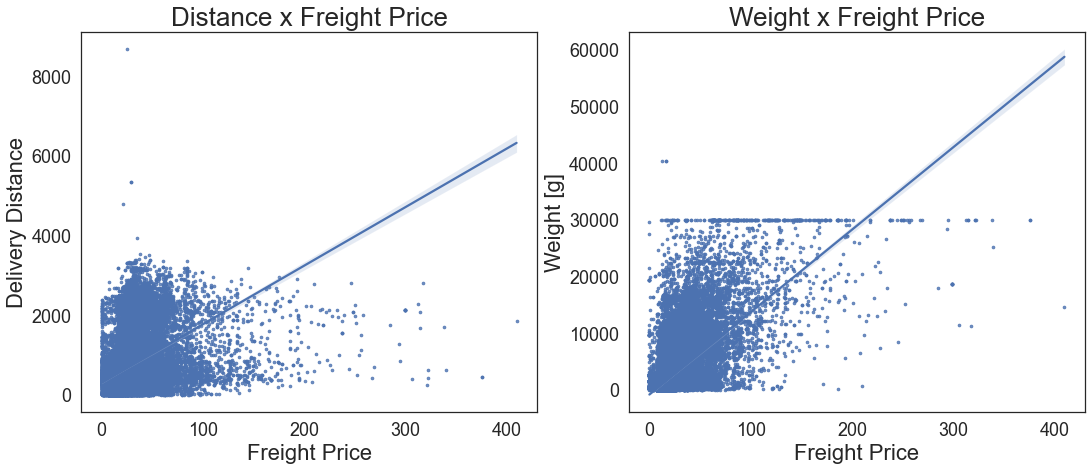

In [85]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,7))

sns.regplot(x=freight_df2['freight_value'], y=freight_df2['delivery_distance'], scatter_kws={'s':7},ax=ax1)
ax1.set_title("Distance x Freight Price",fontsize = 26)
ax1.set_xlabel("Freight Price",fontsize=22)
ax1.set_ylabel("Delivery Distance",fontsize=22)
ax1.tick_params(labelsize=18)


sns.regplot(x=freight_df2['freight_value'], y=freight_df2['product_weight_g'],scatter_kws={'s':7},ax=ax2)
ax2.set_title("Weight x Freight Price",fontsize = 26)
ax2.set_xlabel("Freight Price",fontsize=22)
ax2.set_ylabel("Weight [g]",fontsize=22)
ax2.tick_params(labelsize=18)

Those views were very insightful. First of all, we notice that the biggest freight, in many cases, may not be explained by heavy weights neither long distances. We also note that we have some distance and weight outliers that will probably have a negative effect on our model. So we will drop outliers by these rules:

+ drop lines with freight > 250 and weight < 28000
+ drop lines with freight > 150 and weight < 7500
+ drop lines with weight > 35000
+ drop lines with distance > 4000


In [100]:
#Before droping, lets check if we are not droping to much info

print(f'Rule 1 len: {len(freight_df2[(freight_df2.freight_value>250) & (freight_df2.product_weight_g<25000)])}'
      f'\nRule 2 len: {len(freight_df2[(freight_df2.freight_value>150) & (freight_df2.product_weight_g<7500)])}'
      f'\nRule 3 len: {len(freight_df2[freight_df2.product_weight_g>35000])}'
      f'\nRule 4 len: {len(freight_df2[freight_df2.delivery_distance>4000])}')

Rule 1 len: 11
Rule 2 len: 7
Rule 3 len: 3
Rule 4 len: 4


Only a few data will be dropped, looks like we are good to continue

In [98]:
freight_df3 = freight_df2.copy()

freight_df3 = freight_df3[~((freight_df3.freight_value>250) & (freight_df3.product_weight_g<25000))]
freight_df3 = freight_df3[~((freight_df3.freight_value>150) & (freight_df3.product_weight_g<7500))]
freight_df3 = freight_df3[freight_df3.product_weight_g<35000]
freight_df3 = freight_df3[freight_df3.delivery_distance<4000]

freight_df3.reset_index(drop = True, inplace = True)
print(freight_df3.shape)
freight_df3.head(3)

(110154, 14)


,freight_value,price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state,seller_state,customer_lat,customer_lng,seller_lat,seller_lng,delivery_distance,product_volume
0,13.29,58.9,650.0,28.0,9.0,14.0,RJ,SP,-21.762775,-41.309633,-22.496953,-44.127492,301.504681,3528.0
1,17.96,55.9,650.0,28.0,9.0,14.0,GO,SP,-17.884337,-51.716990,-22.496953,-44.127492,943.308218,3528.0
2,18.33,64.9,650.0,28.0,9.0,14.0,MG,SP,-19.914323,-43.975703,-22.496953,-44.127492,287.605969,3528.0


# EDA and Final Feature Engineering

First of all, we can drop all the info that were used to create new features like: all the coordinates and product measurements 

In [106]:
freight_df4 = freight_df3.drop(['product_length_cm','product_height_cm','product_width_cm',
                                'customer_lat','customer_lng','seller_lat','seller_lng'],axis = 1)

freight_df4.head(1)

,freight_value,price,product_weight_g,customer_state,seller_state,delivery_distance,product_volume
0,13.29,58.9,650.0,RJ,SP,301.504681,3528.0


In [107]:
#lets take a quick look at the correlations 

freight_df4.corr()

,freight_value,price,product_weight_g,delivery_distance,product_volume
freight_value,1.000000,0.409372,0.617327,0.396433,0.586424
price,0.409372,1.000000,0.341936,0.087225,0.300409
product_weight_g,0.617327,0.341936,1.000000,-0.007691,0.806202
delivery_distance,0.396433,0.087225,-0.007691,1.000000,-0.011237
product_volume,0.586424,0.300409,0.806202,-0.011237,1.000000


apparently our features make sense. Now we only have to deal with the seller and customer state info. Does the delivery distance is enough or we could improve our model with dummy variables about the state? 

To answer that question lets start comparing freight, state and distance.

In [115]:
#first, lets create a summary

seller_states_summary = freight_df4.groupby('seller_state').agg({'freight_value':'mean',
                                                                 'price':'mean',
                                                                 'product_weight_g':'mean',
                                                                 'delivery_distance':'mean',
                                                                 'product_volume':'mean',
                                                                 'customer_state':'count'})

seller_states_summary.sort_values(by =['customer_state'],ascending = False,inplace = True)
seller_states_summary.rename(columns = {'customer_state':'qnt_sellers'},inplace = True)

display(seller_states_summary.head(3))

customer_states_summary = freight_df4.groupby('customer_state').agg({'freight_value':'mean',
                                                                 'price':'mean',
                                                                 'product_weight_g':'mean',
                                                                 'delivery_distance':'mean',
                                                                 'product_volume':'mean',
                                                                 'seller_state':'count'})

customer_states_summary.sort_values(by =['seller_state'],ascending = False,inplace = True)
customer_states_summary.rename(columns = {'seller_state':'qnt_customers'},inplace = True)

display(customer_states_summary.head(3))

,freight_value,price,product_weight_g,delivery_distance,product_volume,qnt_sellers
seller_state,,,,,,
SP,18.381738,108.195492,2056.611149,539.590233,15536.033117,78570
MG,23.989008,113.658256,2752.741804,597.102131,15258.589630,8602
PR,22.533275,143.882588,1978.568785,721.597449,14722.920311,8483


,freight_value,price,product_weight_g,delivery_distance,product_volume,qnt_customers
customer_state,,,,,,
SP,15.111047,108.972873,2034.069506,247.631748,15162.523406,46442
RJ,20.898673,124.421479,2254.810622,488.461362,15554.339509,14141
MG,20.609770,119.988060,2164.725062,533.775916,15004.187268,12912


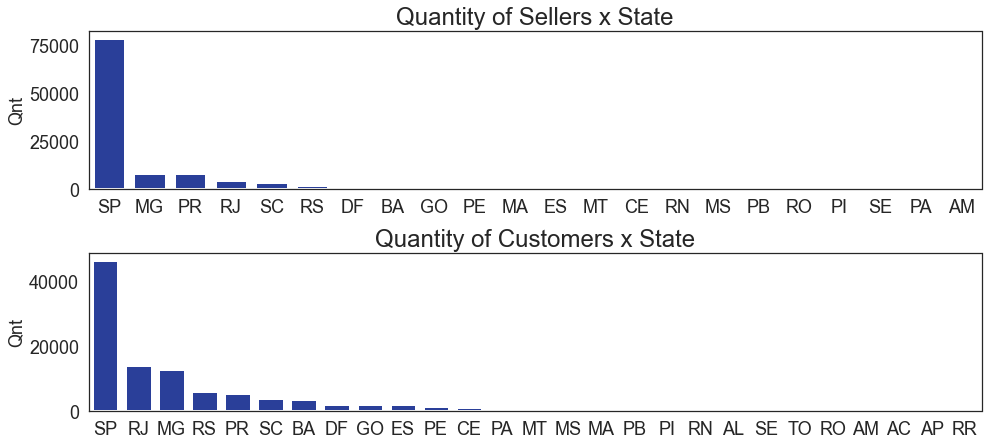

In [124]:
#viewing the data

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,7))

sns.barplot(y=seller_states_summary.qnt_sellers,
            x=seller_states_summary.index,
            color ='#1833ab',lw =3, ax = ax1)

ax1.set_title("Quantity of Sellers x State",fontsize = 24)
ax1.set_ylabel("Qnt",fontsize=18)
ax1.set_xlabel("",fontsize=18)
ax1.tick_params(labelsize=18)

sns.barplot(y=customer_states_summary.qnt_customers,
            x=customer_states_summary.index,
            color ='#1833ab',lw =3, ax = ax2)

ax2.set_title("Quantity of Customers x State",fontsize = 24)
ax2.set_ylabel("Qnt",fontsize=18)
ax2.set_xlabel("",fontsize=18)
ax2.tick_params(labelsize=18)

plt.subplots_adjust(hspace = 0.4)
plt.show()

The majority of sellers and customers are located in SP. Also, RJ and MG are states close to SP. Because of that it will not worth to use dummy variables for states, the delivery distance should be a more reliable feature.

In [126]:
final_freight_df = freight_df4.drop(['customer_state','seller_state'],axis = 1)

final_freight_df.head(3)

,freight_value,price,product_weight_g,delivery_distance,product_volume
0,13.29,58.9,650.0,301.504681,3528.0
1,17.96,55.9,650.0,943.308218,3528.0
2,18.33,64.9,650.0,287.605969,3528.0


# Building the Model

First of all, lets create a Baseline and define our metrics to compare our results. 

Baseline:

The freight varies greatly according to the state of the customer. So to use a mean freight price for each state as estimator seems like a good idea. Besides, we already have a customer summary by states, which will make our job really easy. 

So, to have a robust baseline, we will use two values:

+ Total mean 
+ Mean by customer state

Metrics:

For the metrics, we will use the classic ones for regression models: 

+ MAE: The absolute error is very meaningful to us, considering that we are dealing with a price value
+ RMSE: Very helpful to identify outliers, i.e, big errors  

In [156]:
#remembering our summary and df with seller state info
print('Customer Summary')
display(customer_states_summary.sample(2))

print('Freight df with states info')
freight_df4.sample(2)

,freight_value,price,product_weight_g,delivery_distance,product_volume,qnt_customers
customer_state,,,,,,
PI,38.431228,160.677543,2363.861804,1959.989160,15105.871401,521
RO,41.330549,167.336117,2384.131868,2225.407881,14607.351648,273


,freight_value,price,product_weight_g,customer_state,seller_state,delivery_distance,product_volume
74926,13.88,329.99,838.0,SP,SP,159.535872,8232.0
27732,11.90,99.99,1250.0,SP,SP,95.277290,15750.0


In [208]:
def mae_baseline():
    t_start = perf_counter()
    prov_df = freight_df4.copy()
    
    
    prov_df['mean'] = np.mean(prov_df.freight_value)
    
    prov_df['freight_estimate'] = prov_df.customer_state.apply(
        lambda x:customer_states_summary[customer_states_summary.index == x].freight_value[0])
    
    mae_mean_by_state = mean_absolute_error(prov_df['freight_value'], prov_df['freight_estimate'])
    mae_mean = mean_absolute_error(prov_df['freight_value'], prov_df['mean'])

    rmse_mean_by_state = mean_squared_error(prov_df['freight_value'], prov_df['freight_estimate'], squared=False)
    rmse_mean = mean_squared_error(prov_df['freight_value'], prov_df['mean'], squared=False) 
    
    t_end = perf_counter()
    time = round(t_end-t_start,2) 
    result = pd.DataFrame({'n_estimators':'N\A',
                           'MAE':[mae_mean,mae_mean_by_state],
                           'RMSE':[rmse_mean,rmse_mean_by_state],
                           'time':time},index = ['mean','mean by state'])
    return result

In [209]:
BASELINE = mae_baseline()
BASELINE

,n_estimators,MAE,RMSE,time
mean,N\A,8.548127,15.370855,21.12
mean by state,N\A,7.463449,14.296246,21.12


In [251]:
# X = Train Data
# y = Validation
# n_list = list of n_estimators to test
# model = 'RandomForest'\'XGBoost'

def avaliate_models(X,y,n_list = [50], model_list = ['RandomForest','XGBoost'],l_rate = 0.05):
    
    n_estimators,mae_scores,rmse_scores,models,time =[[] for i in range(5)]
    
    for model in model_list:
        if model == 'RandomForest':
            for n in n_list:
                t_start = perf_counter()
                # Multiply by -1 since sklearn calculates *negative* MAE
                scores = cross_validate(RandomForestRegressor(n_estimators=n, random_state=33),
                                        X, y,
                                        cv=5,
                                        scoring=('neg_mean_absolute_error','neg_root_mean_squared_error'))
                
                t_end = perf_counter()
                time.append(round(t_end-t_start,2))
                n_estimators.append(n)
                mae_scores.append(-1*scores.get('test_neg_mean_absolute_error').mean())
                rmse_scores.append(-1*scores.get('test_neg_root_mean_squared_error').mean())
                models.append(model)
                
        if model == 'XGBoost':
            for n in n_list:
                t_start = perf_counter()
                # Multiply by -1 since sklearn calculates *negative* MAE
                xg_model = XGBRegressor(n_estimators=n, learning_rate= l_rate)
                scores = cross_validate(xg_model,
                                        X, y,
                                        cv=5,
                                        scoring=('neg_mean_absolute_error','neg_root_mean_squared_error'))
                
                t_end = perf_counter()
                time.append(round(t_end-t_start,2))
                n_estimators.append(n)
                mae_scores.append(-1*scores.get('test_neg_mean_absolute_error').mean())
                rmse_scores.append(-1*scores.get('test_neg_root_mean_squared_error').mean())
                models.append(model)
    
    result = pd.DataFrame({'n_estimators':n_estimators,
                           'MAE':mae_scores,
                           'RMSE':rmse_scores,
                           'time':time},index = models)
    
    final_result = pd.concat([BASELINE,result]) 
    final_result.index.name = 'Model'
    return final_result

In [252]:
import warnings
#xgboost shows a warning that will be fixed in the next version
warnings.filterwarnings("ignore")

In [253]:
#lets avaliate 

X = final_freight_df[final_freight_df.columns[1:].tolist()]
y = final_freight_df['freight_value']

model_evaluation =  avaliate_models(X,y,n_list = [5,20,35,50,75,100,150,200])
model_evaluation

,n_estimators,MAE,RMSE,time
Model,,,,
mean,N\A,8.548127,15.370855,21.12
mean by state,N\A,7.463449,14.296246,21.12
RandomForest,5,5.239001,10.190387,7.38
RandomForest,20,4.895589,9.540963,29.53
RandomForest,35,4.837274,9.454350,51.13
RandomForest,50,4.822223,9.428634,74.26
RandomForest,75,4.804260,9.388283,110.16
RandomForest,100,4.796170,9.378993,146.26
RandomForest,150,4.788802,9.364329,218.55


We can see very good improvements from our baselines! 

Its clear that the best model is the XGBoos, with an n_estimators = 75. 

This Model shows:

+ MAE = 4.38
+ RMSE = 8.89

Considering our Baselines metrics: MAE(8.54, 7.46) and RMSE (15.37, 14.29) we can say that our model was able to practically cut the error in half! 


# Model Improvement and Dumping

Our Model showed good results. Even so, we can try optimizing the parameters to improve a little more.

To do so we will perform two steps: 

+ We found an good n_estimator = 75, lets investigating if there is an n_estimator around 75 that is even better
+ the learning_rate can dramatically change the results, let's iterate between some values to see if we can improve our metrics

In [242]:
#trying n_estimators around 75

model_optimize =  avaliate_models(X,y, model_list = ['XGBoost'],n_list = [50,60,70,75,80,90,100])
model_optimize

,n_estimators,MAE,RMSE,time
Model,,,,
mean,N\A,8.548127,15.370855,21.12
mean by state,N\A,7.463449,14.296246,21.12
XGBoost,50,4.376552,9.122383,10.95
XGBoost,60,4.347264,9.025423,13.27
XGBoost,70,4.369847,8.987300,15.71
XGBoost,75,4.385038,8.983817,16.73
XGBoost,80,4.398101,8.980434,17.87
XGBoost,90,4.417553,8.978506,20.57
XGBoost,100,4.430300,8.984024,22.51


Setting the n_estimators to 70 instead of 75 gives an improvement of 0.35% for MAE while the RMSE get only 0.04% worse. 

Therefore, we will use a n_estimators = 70

In [243]:
#Now, let's see if we can improve our model even more, changing the learning rate

learning_rate_list = [0.02,0.03,0.04,0.045,0.05,0.055,0.06,0.07,0.1]
mae, rmse = [[] for i in range(2)]

for rate in learning_rate_list:
    model_improvement =  avaliate_models(X,y,n_list = [70],model_list = ['XGBoost'],l_rate = rate)
    mae.append(model_improvement.MAE['XGBoost'])
    rmse.append(model_improvement.RMSE['XGBoost']) 
    
model_improvement_df = pd.DataFrame({'learning_rate':learning_rate_list, 'MAE':mae,'RMSE':rmse})
model_improvement_df

,learning_rate,MAE,RMSE
0,0.020,5.805020,10.560391
1,0.030,4.556646,9.350639
2,0.040,4.347364,9.063756
3,0.045,4.355609,9.022328
4,0.050,4.369847,8.987300
5,0.055,4.395581,8.985762
6,0.060,4.408262,8.970291
7,0.070,4.438693,9.019340
8,0.100,4.454635,9.022346


Apparently, 0.05 was a good learning rate. We will keep it.

In [246]:
# Fit the model
model = XGBRegressor(n_estimators=70, learning_rate= 0.05)
model.fit(X, y)

# save the model to disk
filename = 'freight_estimate_model.sav'
pickle.dump(model, open(filename, 'wb'))